#Introduction to seismology 


* Earthquakes and faulting (& statistics)
* Elastic waves (waveforms & numerical modelling)
* Tomography (& inverse theory, exploration)


    - note, this is (mostly) a live generated lecture, expect delays, bugs, etc ...

In [2]:
%pylab inline
from __future__ import print_function
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 6, 4

import numpy as np
from mpl_toolkits.basemap import Basemap
import obspy
from obspy.imaging.beachball import beach
import os
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from matplotlib import cm, rcParams

Populating the interactive namespace from numpy and matplotlib


##Earthquakes and faulting

* geological faults provide fairly convincing evidence of the brittle nature of deformation in the earth's lithosphere.

* Seismology has traditionally focussed on measuring an interpreting the elastic waves that sudden slips produce.


<img src="./images/darfield_rupture.jpg " alt="Drawing" style="width: 300px;"/>

In [2]:
client = Client("IRIS")
start = UTCDateTime("2014-09-01T15:10:00")
end= UTCDateTime.now()
cat = client.get_events(starttime=start, endtime=end,latitude=-38.1, longitude=144.00,minradius=0., maxradius=2.)
inv = client.get_stations(longitude=144.00, latitude=-38.1, maxradius=2, level="channel")

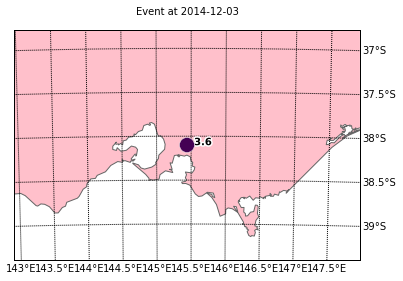

In [6]:

evplot = cat.plot(projection="local", resolution='i', continent_fill_color="pink")

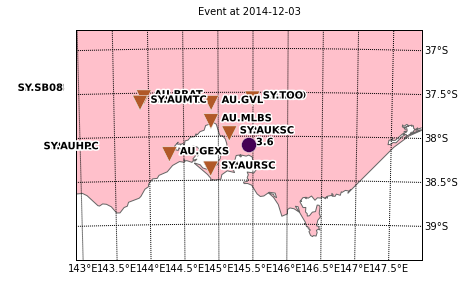

In [103]:
#plot inventory, reusing mpl Figure

inv.plot(fig=evplot)

As in all physics, seismology employs approximations; earthquakes are commonly approximated as infinitesimally localized events in space, i.e. at the hypocenter, which begin at an instant, the origin time.

![Alt text](./images/hypocenter.jpeg)

In [3]:
#Chile quake
catalog = obspy.read_events('./data/SPUD_NDK_bundle_2015-09-21T07.43.47.txt')
filtered = (
    catalog.filter('magnitude >= 8.0', 'magnitude <= 9', 
                   'time > 2005-05-01T00:00')
)

clon = floor(filtered[0]['origins'][0]['longitude'])
clat = floor(filtered[0]['origins'][0]['latitude'])

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-77.0,-37.0,-67.0,-27.0&bboxSR=4326&imageSR=4326&size=1500,1500&dpi=96&format=png32&f=image


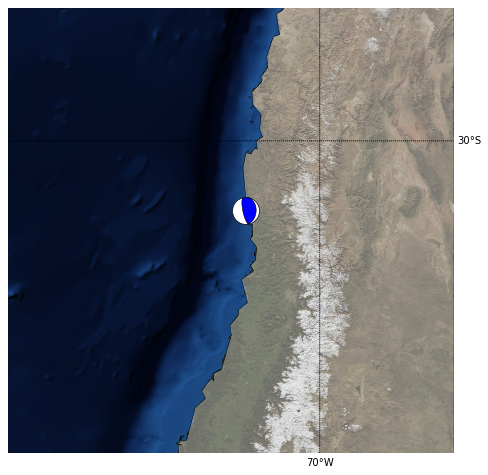

In [7]:
m = Basemap(projection='cyl',llcrnrlat=clat - 5,urcrnrlat= clat + 5,\
            llcrnrlon= clon-5,urcrnrlon=clon+5,resolution='l')

plt.figure(figsize=(8., 8.))
ax = plt.subplot(111)

###########
#Earthquakes
###########
for event in filtered:
    fc = event.focal_mechanisms[0]
    plane = fc.nodal_planes.nodal_plane_1
    origin = event.origins[0]
    depth = origin
    bb = beach([plane.strike, plane.dip, plane.rake], xy=m(origin.longitude, origin.latitude), 
               width=0.6, linewidth=0.5, facecolor='b')
    ax.add_collection(bb)

m.fillcontinents(alpha=0.5)

m.drawparallels(np.arange(-90.,91.,10.), labels=[False,True,True,False])
m.drawmeridians(np.arange(-180.,181.,10.), labels=[True,False,False,True])
#m.etopo(alpha=0.5)
m.drawcoastlines(linewidth=0.5)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)



<img src="./images/Chile1709_PacificView.png " alt="Drawing" style="width: 600px;"/>

##Earthquake sources, locations and statistics


<img src="./images/focal_mechanism.jpeg " alt="Drawing" style="width: 400px;"/>


In [13]:
'''
Problem 1: Estimation of the epicentral coordinates of a seismic event
'''
import numpy as np
import matplotlib.pyplot as plt

# data
std_d = 0.10  # standard deviation
v = 5
station = np.array([(3, 15), (3, 16), (4, 15), (4, 16), (5, 15), (5, 16)])
t_obs = np.array([3.12, 3.26, 2.98, 3.12, 2.84, 2.98])

X = np.r_[0:20:201j]
Y = np.linspace(0, 20, 201)

# calculate the posterior distribution
sigma_M = np.zeros((len(X), len(Y)))

for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        x = X[i]
        y = Y[j]
        t_cal = np.zeros(t_obs.shape)
        for k in range(t_cal.shape[0]):
            t_cal[k] = ((x - station[k][0])**2 +
                        (y - station[k][1])**2)**0.5 / v
        sigma = 0
        for k in range(t_obs.shape[0]):
            sigma = sigma + (t_cal[k] - t_obs[k])**2
        sigma_M[j, i] = np.exp(sigma/(-2 * std_d**2))

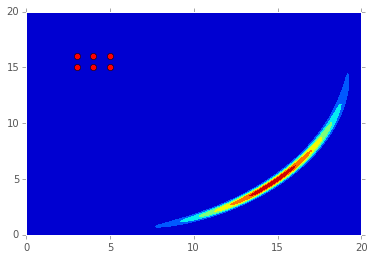

In [14]:
plt.contourf(Y, X, sigma_M,)
xx = [station[0][0], station[1][0], station[2][0],
      station[3][0], station[4][0], station[5][0]]
yy = [station[0][1], station[1][1], station[2][1],
      station[3][1], station[4][1], station[5][1]]
plt.plot(xx, yy, 'ro')
plt.show()

##Elastic waves (waveforms & numerical modelling)

* P & S waves
* surface waves
* conversion
* Rays and travel time curves
* Numerical modelling

For small elastic deformations the relation between the deformation and the resulting stress can be linearised; this linearisation is expressed by Hooke’s law:

$$ F = k\triangle x$$

or in 3d:

$$\tau_{ij} = C_{ijkl}\epsilon_{kl}$$



For isotropic model of elasticity, you will find descriptions using different mixtures of parameters. An isotropic stiffness tensor, like $\bf{C}$ may be formulated as a linear combination of other isotropic unit tensors which fulfill the restriction of being linearly independent among them, hence LAME's constants in some descriptions, YOUNG's modulus and POISSON ratio in others...

But don't worry too much.


![Alt text](./images/hookes.jpeg)


* Elastodynamic waves are vector waves, with no restriction on the polarisation. Because there are three spatial dimensions, elastodynamic waves can have three different polarisations. 

* Waves in a bulk solid can be transverse as well as longitudinal, for a total of three polarization components. 

* Longitudinal waves propagate at a higher velocity than do the transverse waves. The nomenclature “P wave” and “S waves” historically denotes the first arriving (primary) and later arriving (secondary) body waves. 

* There are two directions of polarisation perpendicular, when the medium is anisotropic, there are still three polarisations of the body waves, but they do not correspond to longitudinal and transverse directions of polarisations. Shear wave anisotropy is a major constraint on deep mantle flow.

In [15]:
ev = cat[0]
ot = ev.origins[0]['time']
st = client.get_waveforms("AU", "TOO", "", "*", ot - 0.2 * 60, ot + 1. * 60, attach_response=True)
#st.remove_response(output="VEL")

NameError: name 'cat' is not defined

In [16]:
st.plot()

NameError: name 'st' is not defined

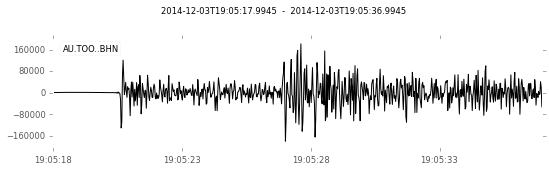

In [53]:
#P and S waves arrivals

st2 = st.copy()
tr = st2[1]
tr.trim(ot+8,ot+27).plot()

### Rays

From a historical point of view, it is interesting that the behavior of ray paths was understood long before ray theory was mathematically formalized. Ray theory originally emerged from optics where it was used to understand the propagation of light even before more fundamental equations for light propagation (Maxwell’s equation) were known. 

Solving the elastic wave equation requires significant computational effort. Ray theory is an alternative approach in which a point on the wavefront is tracked rather than the complete wavefield. Ray theory is strictly valid for media whose length scale variation of $\lambda$ and $\mu$ is much larger than the seismic wavelength (the high frequency assumption). 

From the point of view of modelling, the ray approximation reduced the governign equation from a PDE to ODE. Ray paths and amplitudes are treated seperately.

** In formulating the quantum wave equation, Schrodinger was guided by William R. Hamilton's analogy between mechanics and optics, encoded in the observation that the zero-wavelength limit of optics resembles a mechanical system — the trajectories of light rays become sharp tracks that obey Fermat's principle, an analog of the principle of least action.

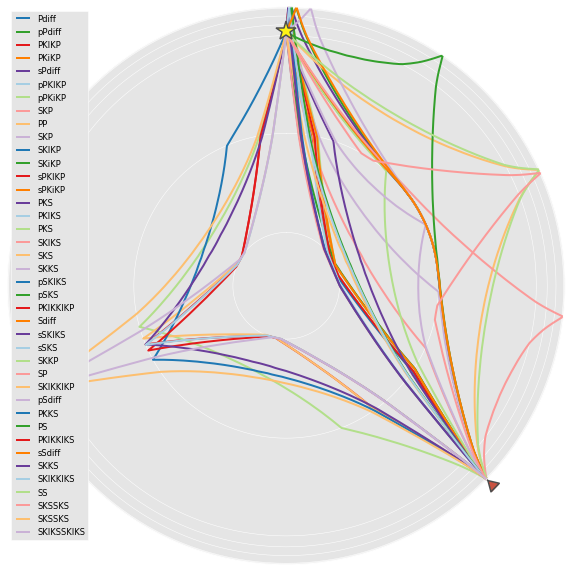

In [17]:
from IPython.html.widgets import interact
from obspy.taup import TauPyModel

m = TauPyModel("ak135")

def plot_raypaths(distance, depth, wavetype):
    try:
        plt.close()
    except:
        pass
    if wavetype == "all":
        phases = ["ttall"]
    elif wavetype == "diff":
        phases = ["Pdiff", "pPdiff"]
    m.get_ray_paths(distance_in_degree=distance,
                    source_depth_in_km=depth,
                    phase_list=phases).plot();
    
interact(plot_raypaths, distance=[0, 180],
         depth=[0, 700], wavetype=["all", "diff"])

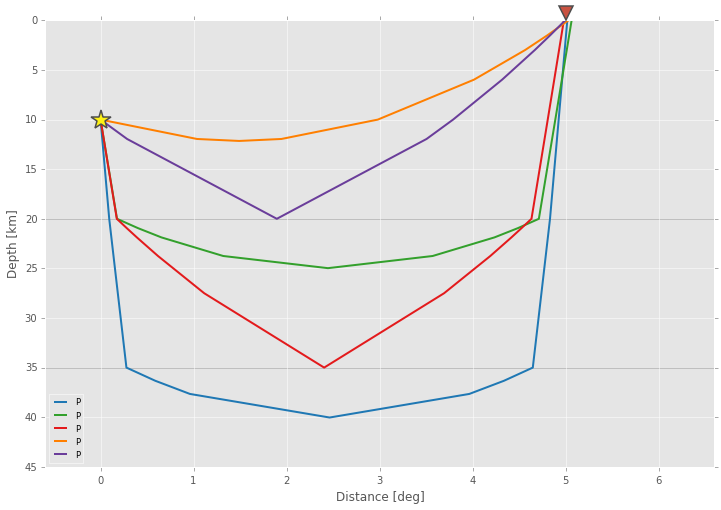

In [18]:
m.get_ray_paths(10, 5, phase_list=["P"]).plot(plot_type="cartesian", plot_all=True)

###Shadow zones

The primary seismic waves are refracted by the liquid outer core of the Earth and are not detected between 104° and 140°

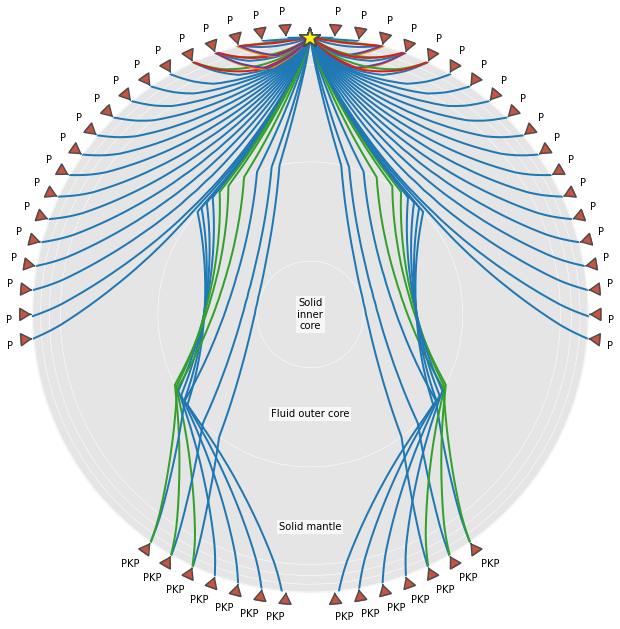

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.taup import TauPyModel
 
# set the velocity model you want to use:
model = TauPyModel(model='iasp91')
 
# set epicentral distances, the phases you want, and a source depth:
DISTANCES=range(0,360,5)
PHASES = ['P','PKP']
sourcedepth=50
 
# ax_right is used for paths plotted on the right half.
fig, ax_right = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax_right.set_theta_zero_location('N')
ax_right.set_theta_direction(-1)
# ax_left is used for paths plotted on the left half.
ax_left = fig.add_axes(ax_right.get_position(), projection='polar',
                       label='twin', frameon=False)
ax_left.set_theta_zero_location('N')
ax_left.set_theta_direction(+1)
ax_left.xaxis.set_visible(False)
ax_left.yaxis.set_visible(False)
 
# Plot all ray paths:
for distance in DISTANCES:
    if distance < 0:
        realdist = -distance
        ax = ax_left
    else:
        realdist = distance
        ax = ax_right
 
    arrivals = model.get_ray_paths(sourcedepth, realdist, phase_list=PHASES)
    if not len(arrivals):
        #print('FAIL', PHASES, distance)
        continue
    arrivals.plot(plot_type='spherical',
                  legend=False, label_arrivals=True,
                  show=False, ax=ax)
 
# Annotate regions:
ax_right.text(0, 0, 'Solid\ninner\ncore',
              horizontalalignment='center', verticalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
ocr = (model.model.radiusOfEarth -
       (model.model.sMod.vMod.iocbDepth + model.model.sMod.vMod.cmbDepth) / 2)
ax_right.text(np.deg2rad(180), ocr, 'Fluid outer core',
              horizontalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
mr = model.model.radiusOfEarth - model.model.sMod.vMod.cmbDepth / 2
ax_right.text(np.deg2rad(180), mr, 'Solid mantle',
              horizontalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
 
plt.show()

/Users/dansandiford/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: ObsPyDeprecationWarning: The travelTimePlot() function is deprecated. Please use the obspy.taup.TauPyModel class directly.


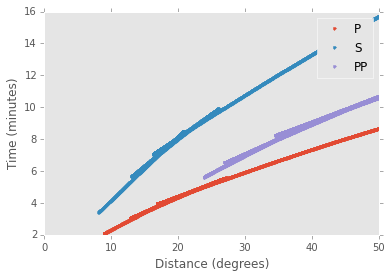

In [3]:
from obspy.taup.taup import travelTimePlot


travelTimePlot(min_degree=0, max_degree=50, phases=['P', 'S', 'PP'],
               depth=120, model='iasp91')

###Numerical models of wave propagation

<IPython.core.display.Javascript object>


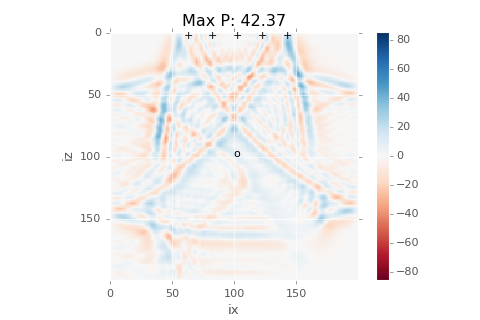

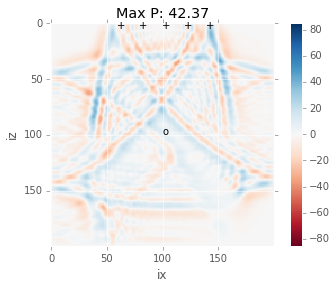

In [15]:
# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# ---------------------------------------------------------
# Simple finite difference solver
#
# Acoustic wave equation  p_tt = c^2 p_xx + src
# 2-D regular grid
# ---------------------------------------------------------

nx = 200      # grid points in x
nz = 200      # grid points in z
nt = 1000      # number of time steps
dx = 10.0     # grid increment in x
dt = 0.001    # Time step
c0 = 3000.0   # velocity (can be an array)
isx = nx / 2  # source index x
isz = nz / 2  # source index z
ist = 100     # shifting of source time function
f0 = 100.0    # dominant frequency of source (Hz)
isnap = 10    # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 3       # length of operator

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "slab"

# Receiver locations
irx = np.array([60, 80, 100, 120, 140])
irz = np.array([5, 5, 5, 5, 5])
seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# Initialize velocity model
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx / 2 - 5: nx / 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:10,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
for it in xrange(nt):
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
src = np.diff(src) / dt
src[nt - 1] = 0

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu)

# Plot the receivers
for x, z in zip(irx, irz):
    plt.text(x, z, '+')

plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')

plt.ion()
#plt.show()


# required for seismograms
ir = np.arange(len(irx))


# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in xrange(1, nx - 1):
            pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
        for j in xrange(1, nz - 1):
            pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in xrange(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in xrange(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
    pxx /= dx ** 2
    pzz /= dx ** 2

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("Max P: %.2f" % p.max())
        image.set_data(pnew)
        plt.draw()
        plt.ioff()

    pold, p = p, pnew


<matplotlib.colorbar.Colorbar instance at 0x113a39710>

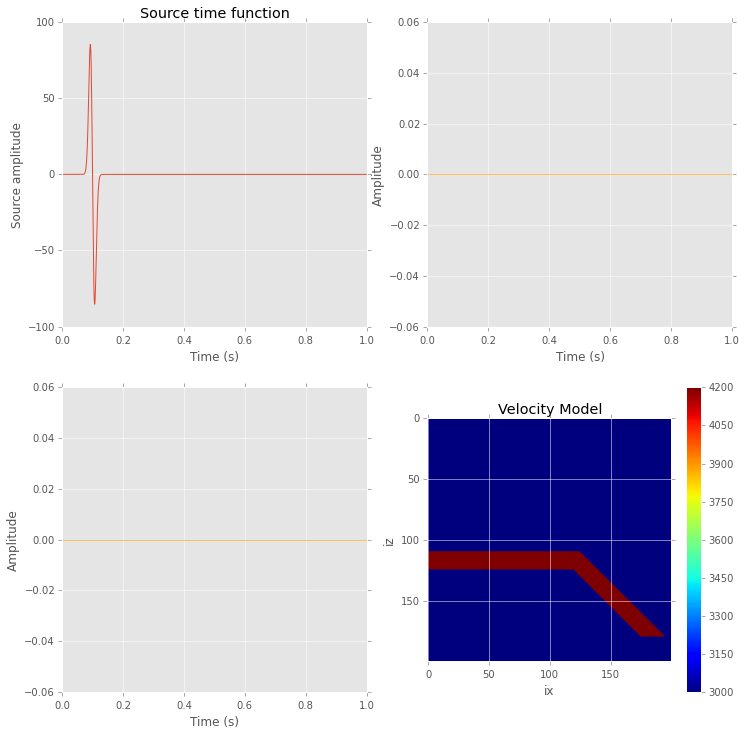

In [16]:
#
# Plot the source time function and the seismograms
#


plt.figure(figsize=(12, 12))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(222)
ymax = seis.ravel().max()  
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(223)
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()


A more sophisticated model...

![Alt text](./images/axisem.png)




In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo("Tx-u_HULFnY")

##Measuring seismic waves and correction

* Seismometers and digitizers (& geophones)
* Instrument correction
* frequency filtering
* rotation


###Seismometer and digitizer

Seismographs operate on the principle of resistance to acceleration, of course all mass moved by the seismic wave resists acceleration.

### Converting raw seismometer recordings to physical units (aka instrument correction)

for this we need to combine the raw waveform data of the recording system (seismometer, digitizer) with the metadata on its amplitude and phase response (the instrument response)
these information are kept separate for various practical and technical reasons (space in storage and streaming, correcting of errors made in the metadata, ...)

3 Trace(s) in Stream:
AU.TOO..BHE | 2014-12-03T19:04:58.019500Z - 2014-12-03T19:06:09.994500Z | 40.0 Hz, 2880 samples
AU.TOO..BHN | 2014-12-03T19:04:58.019500Z - 2014-12-03T19:06:09.994500Z | 40.0 Hz, 2880 samples
AU.TOO..BHZ | 2014-12-03T19:04:58.019500Z - 2014-12-03T19:06:09.994500Z | 40.0 Hz, 2880 samples


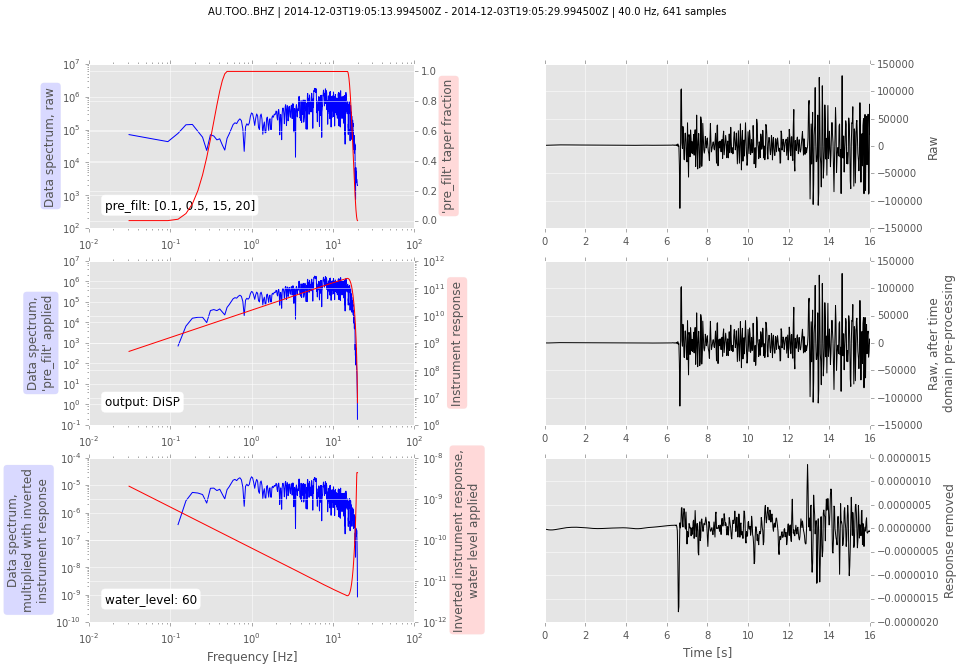

AU.TOO..BHZ | 2014-12-03T19:05:13.994500Z - 2014-12-03T19:05:29.994500Z | 40.0 Hz, 641 samples

In [25]:
#Stream should still be live in the session
print(st)

from obspy import read, read_inventory

# define a filter band to prevent amplifying noise during the deconvolution
tr = st[2]
tr.trim(ot+4, ot+20)
pre_filt = [0.1, 0.5, 15, 20]
output = "DISP"
tr.remove_response(pre_filt=pre_filt, output=output,
                       water_level=60, plot=True)


In [ ]:
from obspy.signal import rotate
R, T = rotate.rotate_NE_RT(st[1].data, st[2].data, 180)

RTst = obspy.core.Stream()
RTst.append(st[0])

Rtr = obspy.core.Trace(T)
Rtr.stats.sampling_rate = st[0].stats.sampling_rate

Rtr.plot()

## Tomography (& inverse theory, exploration)

Seismic tomography is an imaging technique that uses seismic waves generated by earthquakes and explosions to create computer-generated, threedimensional images of Earth’s interior. 

Methods include:

* travel time tomography
* ambient nose tomography
* finite frequency / full waveform inversion

Seismic imaging is somewhat different to tomography, in that the goal is usually to "restore reflectors to their correct subsurface positions"


## Mathematical background

We will follow the formulation of geophysical inverse problems adopted by traditional text books, like Aster et al. (2013) and Scales et al. (2001).
We begin by defining a vector of observed data $\mathbf{d}^o$ and a function $f_i(\mathbf{p})$ that predicts the value of the ith observation given a vector of parameters $\mathbf{p}$.
These predictions are grouped in a predicted data vector $\mathbf{d}$.

The inverse problem of estimating $\mathbf{p}$ from a set of observations $\mathbf{d}^o$ can be solved through least-squares estimation.
This means finding $\mathbf{p}$ that minimizes

$$\Theta(\mathbf{p}) = ||\mathbf{r}||_2^2 = \mathbf{r}^T\mathbf{r}$$

in which $\mathbf{r} = \mathbf{d}^o - \mathbf{d}$ is the residual vector. 

In geophysics, this parameter estimation problem is usually ill-posed and required the addition of prior information.
The traditional way of doing this is through regularization.
Instead of minimizing $\Theta(\mathbf{p})$, we minimize the objective function

$$\Gamma(\mathbf{p}) = \Theta(\mathbf{p}) + \mu \Phi(\mathbf{p})$$

in which $\Phi(\mathbf{p})$ is the regularizing function and $\mu$ is the regularization parameter that controls the trade-off between fitting the data and conforming to prior information.
Many forms of regularization exist in the literature.
The most widely used is Tikhonov regularization (damping and smoothness constraints).
Different forms of regularization have been proposed that impose sharp transitions on the estimated parameters (Martins et al., 2011; Portniaguine and Zhdanov, 1999; Fomel, 2007

##Links to software

Anaconda python
http://continuum.io/downloads

obspy
http://docs.obspy.org/


##Links to software training (e.g. Python)

http://melbourne.resbaz.edu.au/

##People and projects areas


* Gary Gibson (Seismic risk and observation seismology)
* Tim Rawling & Dave Belton (observation seismology, seismic risk, data management)
* Mark Quigley (Neptectonics and Paleoseismology)
* Mike Sandiford (seismo tectonics, surface process feedbacks)
* Louis Moresi (geodynamis models, reciever functions, ambient noise tomography)
* myself (earthquake location, full waveform inversion)

